# Overall
This note book shows the procedure to produce the scalability performance plot from DALiuGE

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0)

## Load the dataset
    0.  user name (e.g. cwu)
    1.  facility (e.g. galaxy)
    2.  pipeline (e.g. lofar_std)
    3.  time (e.g. 2016-08-22T11-52-11/)
    4.  # of nodes
    5.  # of drops
    6.  Git commit number
    7.  unroll_time
    8.  translation_time
    9.  pg_spec_gen_time
    10. created_session_at_all_nodes_time
    11. graph_separation_time
    12. push_sub_graphs_to_all_nodes_time
    13. created_drops_at_all_nodes_time
    14. Num_pyro_connections_at_all_nodes
    15. created_pyro_conn_at_all_nodes_time
    16. triggered_drops_at_all_nodes_time
    17. Total completion time

In [2]:
csv_file = 'presult.csv'
df = pd.read_csv(csv_file, header=None)

num_tests, num_attr = df.shape
print("In total {0} tests run and {1} attributes recorded".format(num_tests, num_attr))
# just show the first three examples
df[0:3]

In total 26 tests run and 18 attributes recorded


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,cwu,magnus,lofar_test_4x4,2016-08-24T10-49-18,9,348,None,0.005,0.285,0.001,0.010,0.002,0.342,0.094,154,0.450999975204,0.0390000343323,-1.000
1,cwu,magnus,lofar_test_32x32,2016-08-25T22-24-39,30,17078,b0142623e6b180de8302273efdc18cb046f389ef,0.350,1.140,0.012,0.018,0.153,0.795,0.382,9186,14.8949999809,2.6400001049,122.511
2,cwu,magnus,lofar_test_128x128,2016-08-25T22-25-00,30,264902,b0142623e6b180de8302273efdc18cb046f389ef,34.399,18.003,0.195,0.019,4.362,2.392,18.319,-1,None,None,-1.000


Show tests that have successfully completed its execution on 30 nodes (sort based on # of drops and # of relationships)

In [3]:
runs_30 = df[(df[4] == 30) & (df[16] != 'None')].sort_values(by=[5, 14])
runs_30[0:3]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
12,cwu,magnus,lofar_test_16x16,2016-08-25T22-24-30,30,4446,b0142623e6b180de8302273efdc18cb046f389ef,0.065,0.446,0.003,0.018,0.032,0.903,0.113,2462,2.39399981499,0.672000169754,42.722
5,cwu,magnus,lofar_test_16x32,2016-08-25T22-24-36,30,8886,b0142623e6b180de8302273efdc18cb046f389ef,0.145,0.684,0.006,0.019,0.069,0.972,0.194,4524,3.68699979782,1.41300010681,193.434
1,cwu,magnus,lofar_test_32x32,2016-08-25T22-24-39,30,17078,b0142623e6b180de8302273efdc18cb046f389ef,0.350,1.140,0.012,0.018,0.153,0.795,0.382,9186,14.8949999809,2.6400001049,122.511


## Plot I
The first set of graph is to show the time spend on varoius metrics when we increase the number of Drops or Drop relationships given a fixed set of nodes (e.g. 30 or 60).

So first define a function

In [4]:
def plot_time_vs_drops(runs_data, x_axis='num_drops'):
    if (x_axis == 'num_rel'):
        x = runs_data.ix[:, 14].values
    else:
        x = runs_data.ix[:, 5].values
    y1 = runs_data.ix[:, 7:13].values 
    y2 = runs_data.ix[:, 15:17].values.astype(float)
    y3 = y2.T[2] - y2.T[1] - y2.T[0] # get the execution time
    y4 = np.vstack([y2.T, y3.T]).T

    labels_1 = ['unroll', 'translate', 'pg_spec', 'session', 'separation', 'push_graph', 'created_drop']
    marker_1 = ['o', 'v', '^', '8', 's', '*', 'D']
    labels_2 = ['relation', 'trigger', 'completion', 'execution']
    marker_2 = marker_1[0:5]
    plt.figure(1)
    plt.subplot(121)
    for i in range(len(labels_1)):
        plt.plot(x, y1[:,i], linewidth=2, label=labels_1[i], 
                 marker=marker_1[i], markersize=8)
    plt.legend(loc='upper left')
    plt.subplot(122)
    for i in range(len(labels_2)):
        plt.plot(x, y4[:,i], linewidth=2, label=labels_2[i], 
                 marker=marker_2[i], markersize=8)
    plt.legend(loc='upper left')


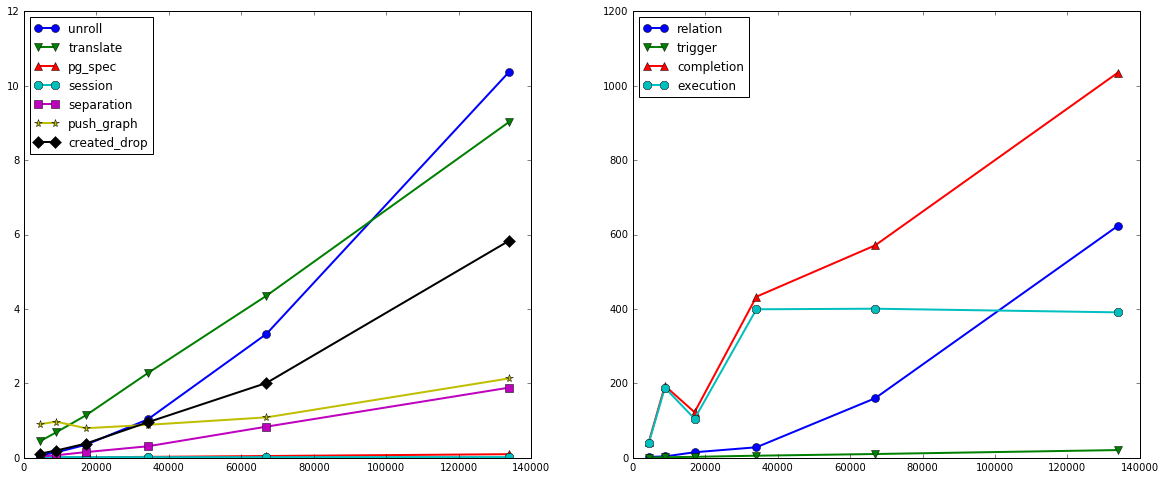

In [5]:
plot_time_vs_drops(runs_30)

In [6]:
runs_60 = df[(df[4] == 60) & (df[16] != 'None')].sort_values(by=[5, 14])
runs_60[0:3]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,cwu,magnus,lofar_test_16x16,2016-08-25T22-27-08,60,4446,b0142623e6b180de8302273efdc18cb046f389ef,0.065,0.466,0.002,0.035,0.039,1.100,0.116,2634,2.51099991798,0.691999912262,42.813
16,cwu,magnus,lofar_test_16x32,2016-08-25T22-27-15,60,8886,b0142623e6b180de8302273efdc18cb046f389ef,0.144,0.714,0.006,0.035,0.082,1.204,0.186,4942,3.94900012016,1.30599999428,51.523
11,cwu,magnus,lofar_test_32x32,2016-08-25T22-27-19,60,17078,b0142623e6b180de8302273efdc18cb046f389ef,0.344,1.153,0.012,0.036,0.175,1.228,0.343,9870,15.2750000954,2.7990000248,56.337


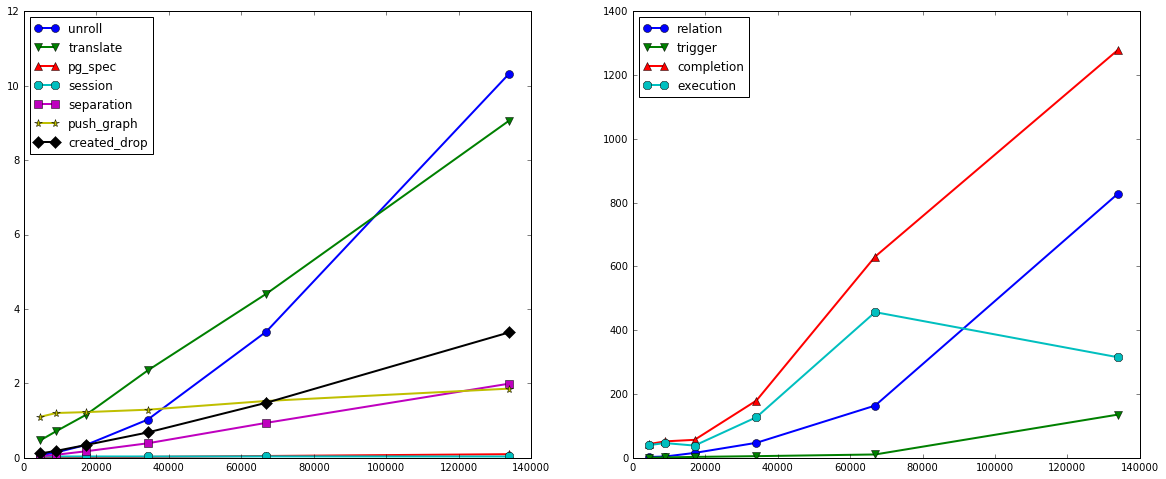

In [7]:
plot_time_vs_drops(runs_60)

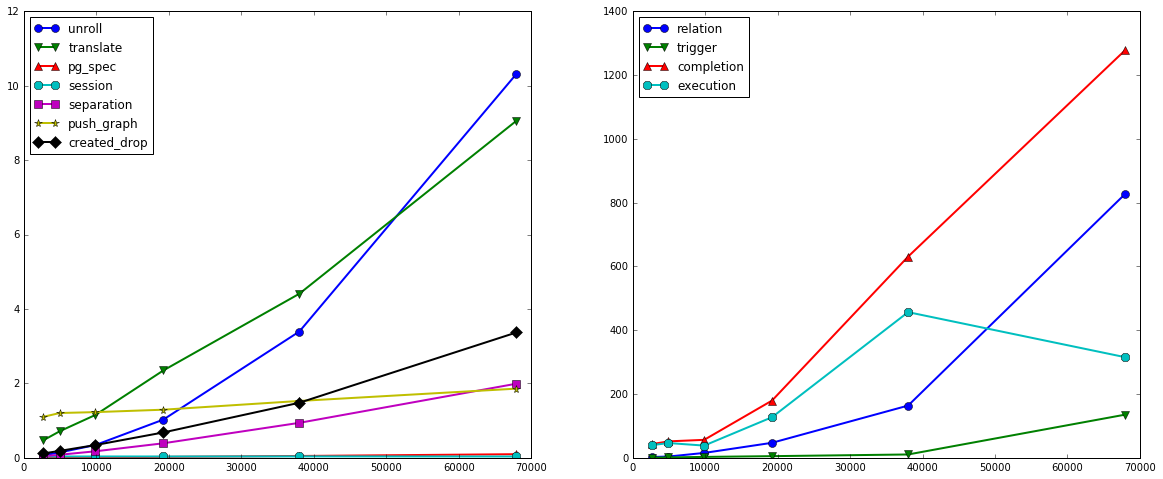

In [8]:
plot_time_vs_drops(runs_60, x_axis='num_rel')